# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version = '26'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data='snow'

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2528737)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 10:06:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qs   = xr.open_dataset(fname).q_snow.values
    ns   = xr.open_dataset(fname).n_snow.values
    cwc  = xr.open_dataset(fname).cwc.values
    # process rates
    self_snow_num  = xr.open_dataset(fname).self_snow.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    p_min = 1e-2
    # transform everything in log space
    ns = np.log(ns, where=ns>n_min, out=np.nan*ns)
    qs = np.log(qs, where=qs>q_min, out=np.nan*qs)
    self_snow_num = np.log(self_snow_num,  where=self_snow_num>p_min, out=np.nan*self_snow_num)    
    # take out cwc > 0
    # self_snow_num  = np.where(cwc < 1e-6, self_snow_num, np.nan*self_snow_num)    
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qs, ns, temp, rho, self_snow_num ]))
    dataset = dataset.T
    dataset.columns = [ 'qs', 'ns', 'temp', 'rho', 'self_snow_num' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

qs            ns          temp           rho  self_snow_num
count  1.623382e+06  1.623382e+06  1.623382e+06  1.623382e+06   1.623382e+06
mean  -7.511523e+00  1.108076e+01  2.434745e+02  7.115004e-01   2.997473e+00
std    1.273978e+00  2.734834e+00  1.217500e+01  1.521104e-01   2.550848e+00
min   -1.581806e+01 -1.398327e+00  2.083000e+02  4.120000e-01  -4.604371e+00
25%   -8.459963e+00  1.014432e+01  2.355200e+02  6.050000e-01   1.324148e+00
50%   -7.570296e+00  1.166358e+01  2.438700e+02  7.040000e-01   3.242592e+00
75%   -6.550990e+00  1.295704e+01  2.513300e+02  7.990000e-01   4.774069e+00
max   -4.012285e+00  1.607404e+01  2.781300e+02  1.274000e+00   1.133710e+01

### Separate in training, validation and test data 70/15/15

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

qs        ns        temp    rho  self_snow_num
23 -10.676500  8.596929  245.339996  0.721      -1.609438
25 -10.609639  8.650149  245.500000  0.723      -1.609438
35 -10.324016  8.902592  246.279999  0.733      -1.609438
36 -10.299617  8.919721  246.360001  0.734      -1.609438
42 -10.146911  9.052516  246.850006  0.741      -0.510826

In [11]:
dataset_train.describe()

qs            ns          temp           rho  self_snow_num
count  1.135918e+06  1.135918e+06  1.135918e+06  1.135918e+06   1.135918e+06
mean  -7.511187e+00  1.108125e+01  2.434718e+02  7.114236e-01   2.997910e+00
std    1.273811e+00  2.734557e+00  1.216478e+01  1.520239e-01   2.551003e+00
min   -1.531091e+01 -1.398327e+00  2.083000e+02  4.120000e-01  -4.604371e+00
25%   -8.460766e+00  1.014354e+01  2.355200e+02  6.050000e-01   1.321756e+00
50%   -7.570334e+00  1.166384e+01  2.438800e+02  7.040000e-01   3.242592e+00
75%   -6.550500e+00  1.295829e+01  2.513200e+02  7.990000e-01   4.774069e+00
max   -4.012341e+00  1.607404e+01  2.781300e+02  1.273000e+00   1.133710e+01

In [12]:
dataset_test.describe()

qs             ns           temp            rho  \
count  243714.000000  243714.000000  243714.000000  243714.000000   
mean       -7.513291      11.081387     243.469055       0.711650   
std         1.274898       2.735582      12.198293       0.152262   
min       -14.867220      -1.290148     208.369995       0.413000   
25%        -8.460234      10.146356     235.500000       0.606000   
50%        -7.570917      11.665303     243.860001       0.704000   
75%        -6.553180      12.955033     251.350006       0.800000   
max        -4.012285      16.023159     278.059998       1.274000   

       self_snow_num  
count  243714.000000  
mean        2.994953  
std         2.549917  
min        -4.599466  
25%         1.318039  
50%         3.242592  
75%         4.763882  
max        11.102516

In [13]:
dataset_val.describe()

qs             ns           temp            rho  \
count  243750.000000  243750.000000  243750.000000  243750.000000   
mean       -7.511315      11.077791     243.492065       0.711709   
std         1.273841       2.735388      12.199289       0.152362   
min       -15.818065      -1.235808     208.639999       0.413000   
25%        -8.455627      10.146796     235.509995       0.605000   
50%        -7.569481      11.661345     243.889999       0.704000   
75%        -6.550728      12.951907     251.380005       0.800000   
max        -4.013890      15.965725     277.910004       1.273000   

       self_snow_num  
count  243750.000000  
mean        2.997952  
std         2.551062  
min        -4.603242  
25%         1.335001  
50%         3.242592  
75%         4.779123  
max        11.057365

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['qs'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

qs            ns          temp           rho  self_snow_num
count  1.135918e+06  1.135918e+06  1.135918e+06  1.135918e+06   1.135918e+06
mean  -7.511187e+00  1.108125e+01  2.434718e+02  7.114236e-01   2.997910e+00
std    1.273811e+00  2.734557e+00  1.216478e+01  1.520239e-01   2.551003e+00
min   -1.531091e+01 -1.398327e+00  2.083000e+02  4.120000e-01  -4.604371e+00
25%   -8.460766e+00  1.014354e+01  2.355200e+02  6.050000e-01   1.321756e+00
50%   -7.570334e+00  1.166384e+01  2.438800e+02  7.040000e-01   3.242592e+00
75%   -6.550500e+00  1.295829e+01  2.513200e+02  7.990000e-01   4.774069e+00
max   -4.012341e+00  1.607404e+01  2.781300e+02  1.273000e+00   1.133710e+01

In [17]:
dataset_test.describe()

qs             ns           temp            rho  \
count  243714.000000  243714.000000  243714.000000  243714.000000   
mean       -7.513291      11.081387     243.469055       0.711650   
std         1.274898       2.735582      12.198293       0.152262   
min       -14.867220      -1.290148     208.369995       0.413000   
25%        -8.460234      10.146356     235.500000       0.606000   
50%        -7.570917      11.665303     243.860001       0.704000   
75%        -6.553180      12.955033     251.350006       0.800000   
max        -4.012285      16.023159     278.059998       1.274000   

       self_snow_num  
count  243714.000000  
mean        2.994953  
std         2.549917  
min        -4.599466  
25%         1.318039  
50%         3.242592  
75%         4.763882  
max        11.102516

### Pairplot

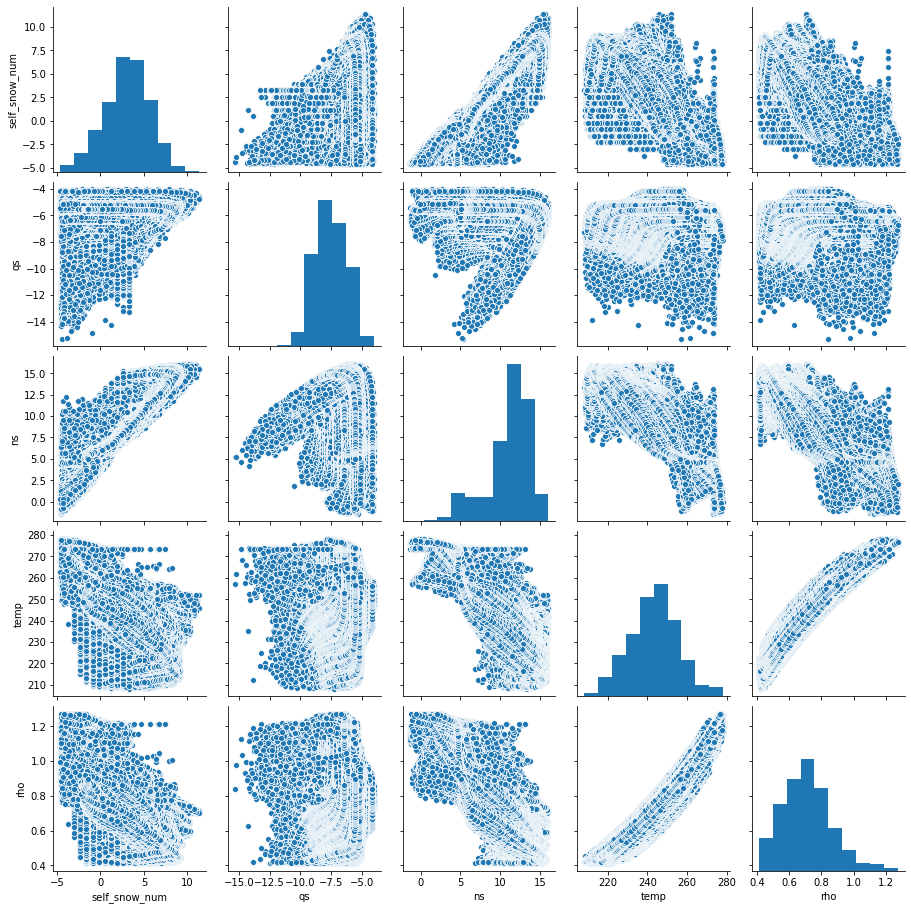

In [18]:
sns.pairplot(dataset_train[["self_snow_num","qs","ns","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self_snow_num")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%       75%  \
qs  1135918.0  -7.511187  1.273811 -15.310905  -8.460766  -7.570334  -6.55050   
ns  1135918.0  11.081252  2.734557  -1.398327  10.143538  11.663842  12.95829   

          max  
qs  -4.012341  
ns  16.074039

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self_snow_num")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean        std         min         25%         50%  \
qs    1135918.0   -7.511187   1.273811  -15.310905   -8.460766   -7.570334   
ns    1135918.0   11.081252   2.734557   -1.398327   10.143538   11.663842   
temp  1135918.0  243.471771  12.164777  208.300003  235.520004  243.880005   

             75%         max  
qs     -6.550500   -4.012341  
ns     12.958290   16.074039  
temp  251.320007  278.130005

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self_snow_num")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
qs    1135918.0   -7.511187   1.273811  -15.310905   -8.460766   -7.570334   
ns    1135918.0   11.081252   2.734557   -1.398327   10.143538   11.663842   
temp  1135918.0  243.471771  12.164777  208.300003  235.520004  243.880005   
rho   1135918.0    0.711424   0.152024    0.412000    0.605000    0.704000   

             75%         max  
qs     -6.550500   -4.012341  
ns     12.958290   16.074039  
temp  251.320007  278.130005  
rho     0.799000    1.273000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['self_snow_num']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

self_snow_num
count   1.135918e+06
mean    2.997910e+00
std     2.551003e+00
min    -4.604371e+00
25%     1.321756e+00
50%     3.242592e+00
75%     4.774069e+00
max     1.133710e+01

In [32]:
train_dataset1.describe()

qs            ns
count  1.135918e+06  1.135918e+06
mean  -7.511187e+00  1.108125e+01
std    1.273811e+00  2.734557e+00
min   -1.531091e+01 -1.398327e+00
25%   -8.460766e+00  1.014354e+01
50%   -7.570334e+00  1.166384e+01
75%   -6.550500e+00  1.295829e+01
max   -4.012341e+00  1.607404e+01

In [33]:
train_dataset2.describe()

qs            ns          temp
count  1.135918e+06  1.135918e+06  1.135918e+06
mean  -7.511187e+00  1.108125e+01  2.434718e+02
std    1.273811e+00  2.734557e+00  1.216478e+01
min   -1.531091e+01 -1.398327e+00  2.083000e+02
25%   -8.460766e+00  1.014354e+01  2.355200e+02
50%   -7.570334e+00  1.166384e+01  2.438800e+02
75%   -6.550500e+00  1.295829e+01  2.513200e+02
max   -4.012341e+00  1.607404e+01  2.781300e+02

In [34]:
train_dataset3.describe()

qs            ns          temp           rho
count  1.135918e+06  1.135918e+06  1.135918e+06  1.135918e+06
mean  -7.511187e+00  1.108125e+01  2.434718e+02  7.114236e-01
std    1.273811e+00  2.734557e+00  1.216478e+01  1.520239e-01
min   -1.531091e+01 -1.398327e+00  2.083000e+02  4.120000e-01
25%   -8.460766e+00  1.014354e+01  2.355200e+02  6.050000e-01
50%   -7.570334e+00  1.166384e+01  2.438800e+02  7.040000e-01
75%   -6.550500e+00  1.295829e+01  2.513200e+02  7.990000e-01
max   -4.012341e+00  1.607404e+01  2.781300e+02  1.273000e+00

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qs  1135918.0  8.440010e-08  1.0 -6.123137 -0.745463 -0.046434  0.754183   
ns  1135918.0 -1.064892e-07  1.0 -4.563657 -0.342913  0.213047  0.686414   

         max  
qs  2.746755  
ns  1.825812

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qs    1135918.0  8.440010e-08  1.0 -6.123137 -0.745463 -0.046434  0.754183   
ns    1135918.0 -1.064892e-07  1.0 -4.563657 -0.342913  0.213047  0.686414   
temp  1135918.0  3.064945e-07  1.0 -2.891279 -0.653671  0.033559  0.645161   

           max  
qs    2.746755  
ns    1.825812  
temp  2.849064

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qs    1135918.0  8.440010e-08  1.0 -6.123137 -0.745463 -0.046434  0.754183   
ns    1135918.0 -1.064892e-07  1.0 -4.563657 -0.342913  0.213047  0.686414   
temp  1135918.0  3.064945e-07  1.0 -2.891279 -0.653671  0.033559  0.645161   
rho   1135918.0 -2.218768e-06  1.0 -1.969583 -0.700045 -0.048832  0.576070   

           max  
qs    2.746755  
ns    1.825812  
temp  2.849064  
rho   3.694001

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count     mean       std       min       25%       50%  \
self_snow_num  1135918.0  2.99791  2.551003 -4.604371  1.321756  3.242592   

                    75%        max  
self_snow_num  4.774069  11.337097

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(2,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8623207 ],
       [-0.862399  ],
       [-0.8626421 ],
       [-0.86267483],
       [-0.86279625],
       [-0.8628261 ],
       [-0.8628731 ],
       [-0.86308455],
       [-0.86310637],
       [-0.8631227 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [47]:
activ = "ReLU_Adam"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0674,  mae:0.2031,  mse:0.0674,  val_loss:0.0613,  val_mae:0.1945,  val_mse:0.0613,  
........................................

Text(0, 0.5, 'MAE')

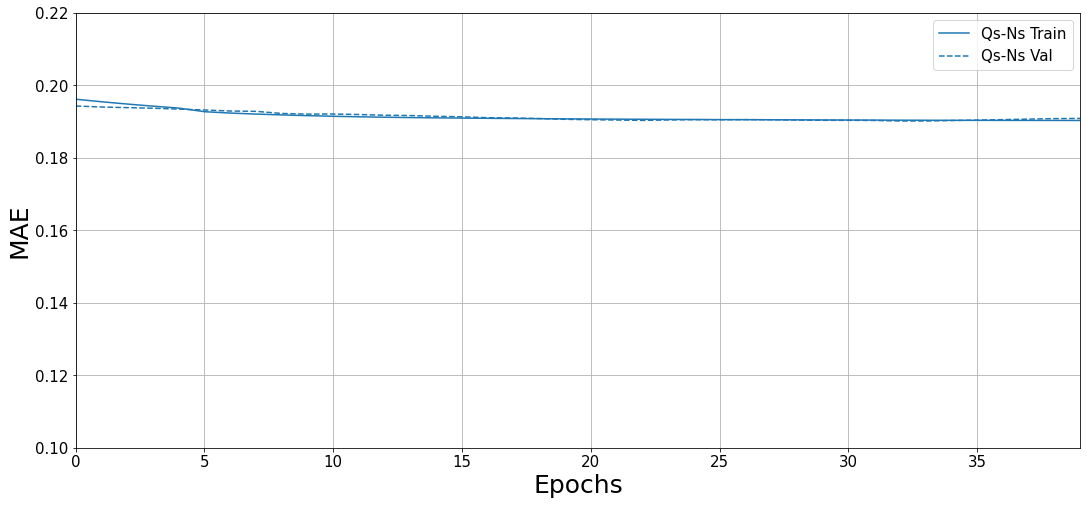

In [48]:
histories['qs-ns'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.22])
plt.ylabel('MAE')

In [49]:
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0333,  mae:0.1288,  mse:0.0333,  val_loss:0.0271,  val_mae:0.1180,  val_mse:0.0271,  
.................................................

Text(0, 0.5, 'MAE')

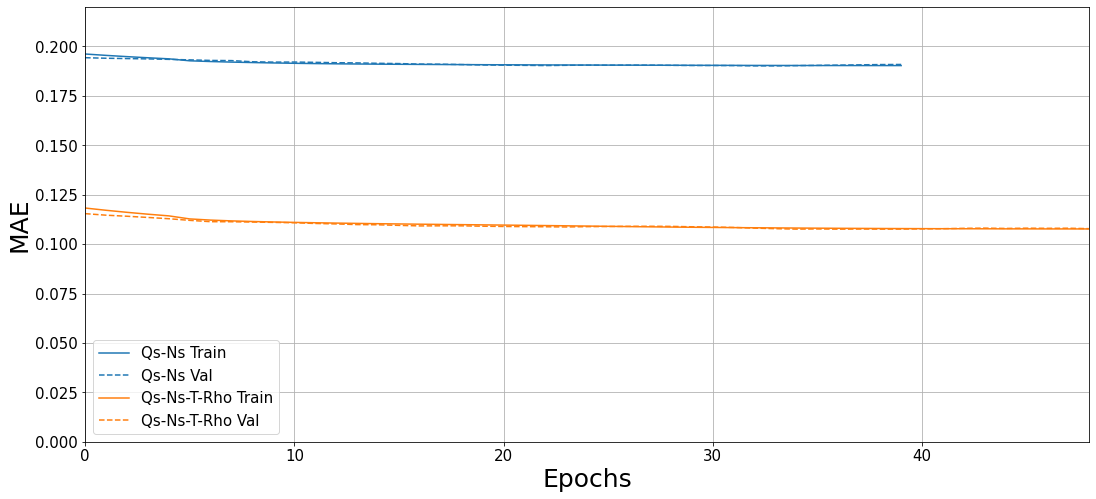

In [51]:
histories['qs-ns-T-rho'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.00, 0.22])
plt.ylabel('MAE')

In [52]:
nsize = 32
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0310,  mae:0.1245,  mse:0.0310,  val_loss:0.0259,  val_mae:0.1142,  val_mse:0.0259,  
..........................................................................................

Text(0, 0.5, 'MAE')

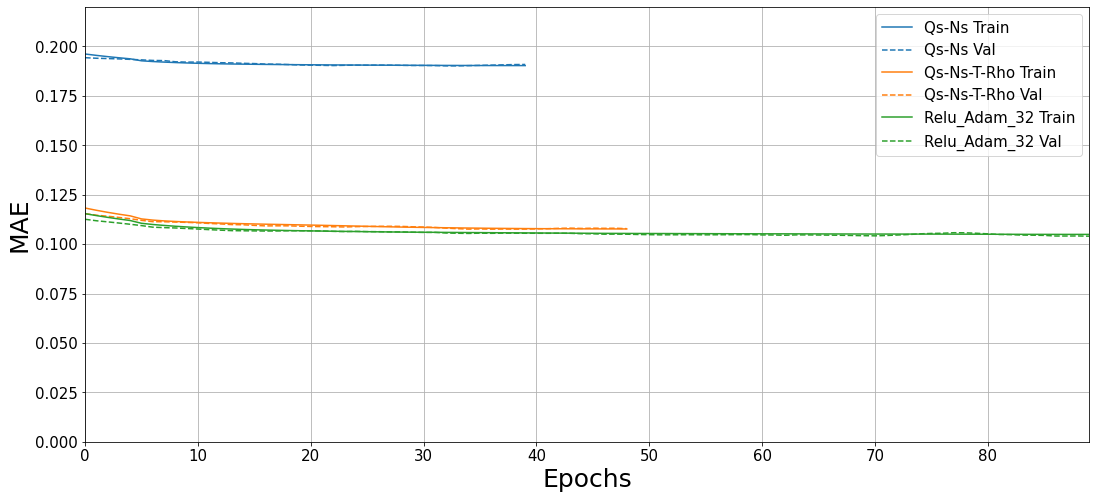

In [53]:
histories['ReLU_Adam_32'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0, 0.22])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

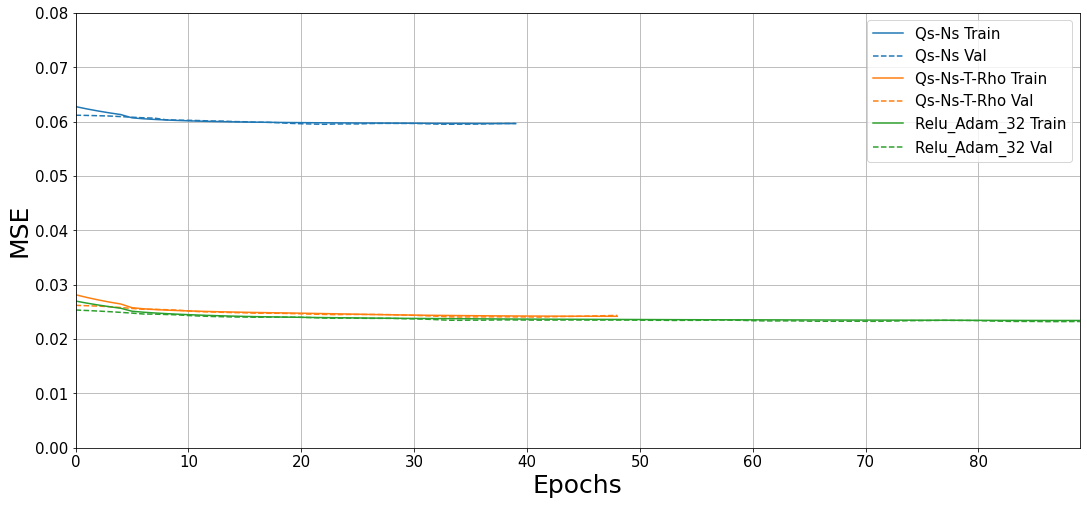

In [55]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.0, 0.08])
plt.ylabel('MSE')

In [56]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)#

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

243714/243714 - 6s - loss: 0.0594 - mae: 0.1892 - mse: 0.0594
Testing set for model 1, Mean Abs Error:    0.18919


In [57]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

243714/243714 - 6s - loss: 0.0239 - mae: 0.1066 - mse: 0.0239
Testing set for model 2, Mean Abs Error:              0.10662


In [58]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

243714/243714 - 6s - loss: 0.0231 - mae: 0.1038 - mse: 0.0231
Testing set for model 3, Mean Abs Error:              0.10385


In [59]:
mae = [ mae1, mae2, mae3 ]
mae

[0.1891892, 0.10661762, 0.10384751]

In [60]:
mse = [ mse1, mse2, mse3 ]
mse

[0.059382536, 0.023888906, 0.023103923]

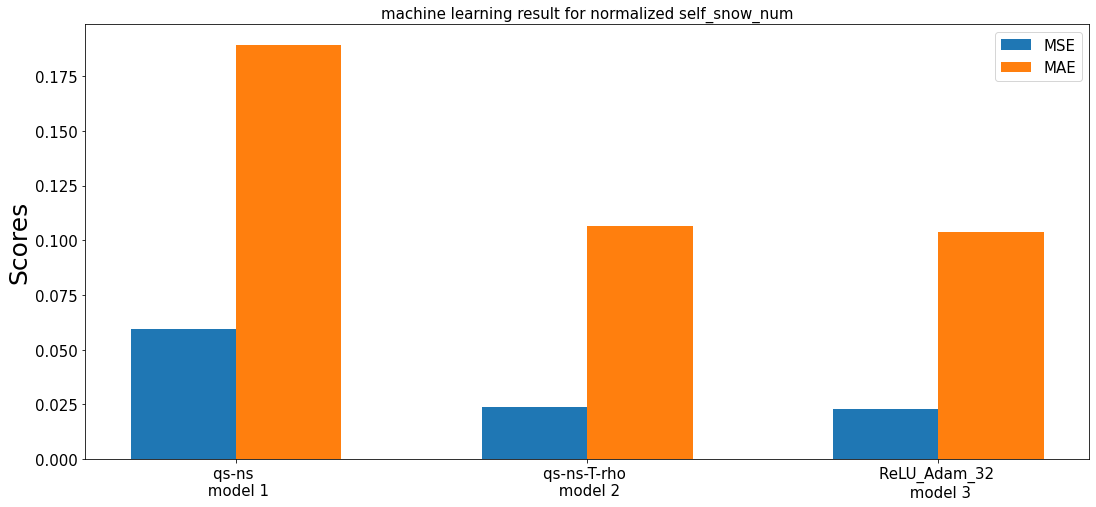

In [61]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['qs-ns \n model 1',
 'qs-ns-T-rho \n model 2',
 'ReLU_Adam_32 \n model 3' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized self_snow_num')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [62]:
test_true_self_snow_num  = np.exp(test_labels.pop('self_snow_num'))

In [63]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [64]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["self_snow_num"])

In [65]:
p1.describe()

self_snow_num
count  243714.000000
mean        0.005288
std         0.966391
min        -3.545484
25%        -0.616768
50%         0.088311
75%         0.659433
max         3.095869

In [66]:
train_labels_stats

count     mean       std       min       25%       50%  \
self_snow_num  1135918.0  2.99791  2.551003 -4.604371  1.321756  3.242592   

                    75%        max  
self_snow_num  4.774069  11.337097

In [67]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [68]:
test_predict1.describe()

self_snow_num
count  243714.000000
mean      213.673101
std       804.245639
min         0.002366
25%         4.155915
50%        25.108136
75%       107.783697
max     53932.159420

In [69]:
test_predict1_self_snow_num  = test_predict1['self_snow_num']

In [70]:
p2 = pd.DataFrame(data=model2.predict(normed_test_data3), columns=["self_snow_num"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_self_snow_num  = test_predict2['self_snow_num']

In [71]:
p3 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["self_snow_num"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_self_snow_num  = test_predict3['self_snow_num']

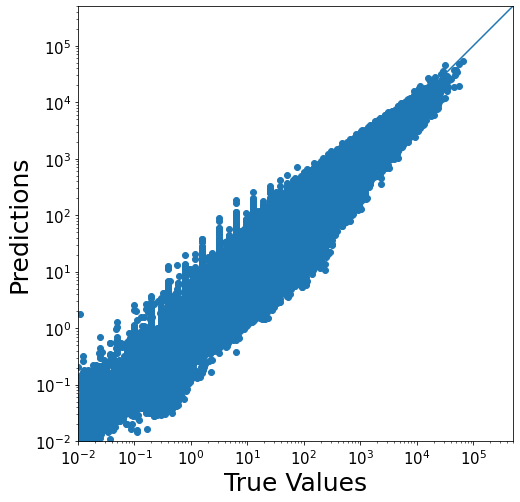

In [72]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-2, 5e5

a = plt.axes(aspect='equal')
plt.scatter(test_true_self_snow_num, test_predict1_self_snow_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

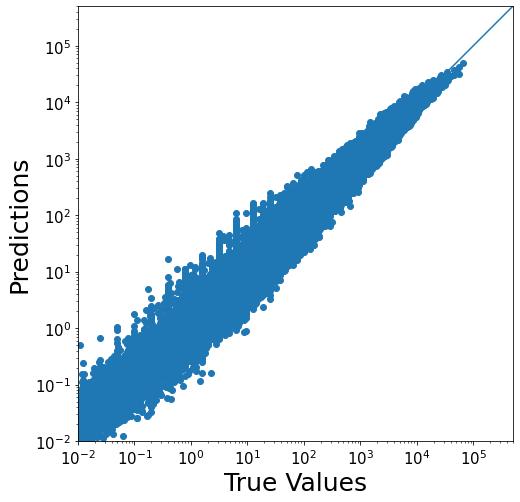

In [73]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_snow_num, test_predict2_self_snow_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

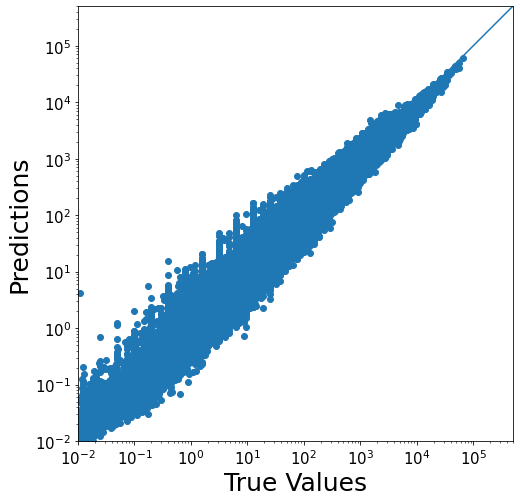

In [74]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_snow_num, test_predict3_self_snow_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [75]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2

In [76]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [77]:
features = 'qs, ns'
labels   = 'self_snow_num, self_snow_mass'
filename = 'saved_model_v2/self_snow_model1_'+version+'.nc'
logtransform = np.array([True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/self_snow_model1_26.nc
  Features:   qs, ns
  Labels:     self_snow_num, self_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear


In [78]:
features = 'qs, ns, T, rho'
logtransform = np.array([True, True, False, False], dtype=bool)

filename = 'saved_model_v2/self_snow_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/self_snow_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/self_snow_model2_26.nc
  Features:   qs, ns, T, rho
  Labels:     self_snow_num, self_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/self_snow_model3_26.nc
  Features:   qs, ns, T, rho
  Labels:     self_snow_num, self_snow_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 1), Activation: linear
